In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'train.csv', 'sampleSubmission.csv']


Problem statement: Predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

In [2]:
# importing libraries
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import calendar

from datetime import datetime

import matplotlib
from matplotlib import pyplot as plt

import seaborn as sns

%matplotlib inline

In [3]:
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')
df_sampleSubmission = pd.read_csv('../input/sampleSubmission.csv')

In [4]:
print('Training data shape',df_train.shape)
print('Test data shape',df_test.shape)


Training data shape (10886, 12)
Test data shape (6493, 9)


Lets learn about the training data set.

In [5]:
print('Training data set header')
df_train.head()

Training data set header


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
print('Training data set data types')
df_train.dtypes

Training data set data types


datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

In [7]:
# to apply a function on each value in a series, use apply and lambda as below. [0] in the end is index of 
# first element in split.
df_train['date']=df_train['datetime'].apply(lambda x: x.split()[0])



In [8]:
df_train['Hour']=df_train['datetime'].apply(lambda x:x.split()[1].split(':')[0])

In [9]:
df_train['weekday']=df_train['date'].apply(lambda x: calendar.day_name[datetime.strptime(x,'%Y-%m-%d').weekday()])


In [10]:
# In datetime library, strptime is to create a datetime object a date into year, month, date, hour and minute. 
# Weekday returns the weekday of that date. with 0 as Monday
datetime.strptime(df_train['datetime'][2],'%Y-%m-%d %H:%M:%S').weekday()

5

In [11]:
df_train['Month'] = df_train['date'].apply(lambda x: calendar.month_name[datetime.strptime(x,'%Y-%m-%d').month])


In [12]:
df_train['season'] = df_train['season'].map({1:'Spring',2:'Summer',3:'Fall',4:'Winter'})
df_train['weather'] = df_train['weather'].map({1:'Clear + Few clouds + Partly cloudy + Partly cloudy',
                                               2:'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',
                                               3:'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
                                               4:'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog'})

In [13]:
categorical_columns=['season','weather','Hour','weekday','Month','holiday','workingday']

for col in categorical_columns:
    df_train[col] = df_train[col].astype('category') 

df_train.dtypes

datetime        object
season        category
holiday       category
workingday    category
weather       category
temp           float64
atemp          float64
humidity         int64
windspeed      float64
casual           int64
registered       int64
count            int64
date            object
Hour          category
weekday       category
Month         category
dtype: object

In [14]:
df_train = df_train.drop(['datetime'],axis=1)

In [15]:
print('Step 1: Find missing values')
print('Is there any missing value?',df_train.isnull().values.any())


Step 1: Find missing values
Is there any missing value? False


----Step2: Outlier analysis----
Using box plot we can find the outliers


[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Working day'),
 Text(0.5, 1.0, 'Plot on Working day(or not) vs Count')]

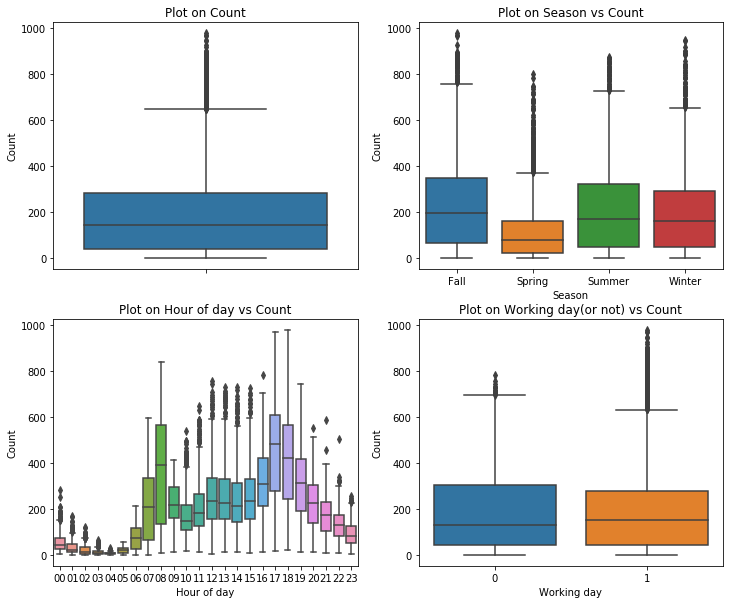

In [16]:
print('----Step2: Outlier analysis----')

print('Using box plot we can find the outliers')

#returns a figure with 4 subplots (2 on each row)
fig,ax= plt.subplots(nrows=2,ncols=2)
#set figure size
fig.set_size_inches(12,10)
sns.boxplot(data=df_train,y='count',orient='v',ax=ax[0][0])
sns.boxplot(data=df_train,y='count', x='season', orient='v',ax=ax[0][1])
sns.boxplot(data=df_train,y='count', x='Hour',orient='v',ax=ax[1][0])
sns.boxplot(data=df_train,y='count', x='workingday',orient='v',ax=ax[1][1])

ax[0][0].set(ylabel='Count', title = 'Plot on Count')
ax[0][1].set(ylabel='Count', xlabel = 'Season', title = 'Plot on Season vs Count')
ax[1][0].set(ylabel='Count', xlabel = 'Hour of day', title = 'Plot on Hour of day vs Count')
ax[1][1].set(ylabel='Count', xlabel = 'Working day', title = 'Plot on Working day(or not) vs Count')

In [17]:
df_train_corr = df_train.corr()
df_train_corr

,temp,atemp,humidity,windspeed,casual,registered,count
temp,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454
atemp,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784
humidity,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371
windspeed,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369
casual,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414
registered,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948
count,0.394454,0.389784,-0.317371,0.101369,0.690414,0.970948,1.000000


The correlation between count and temp is +ve. temp and atemp are same, so removing atemp won't harm us.
Humidity and count has negative correlation. Indicating, whenever humidity is high, number of people renting bike is low.
Correlation of count with windspeed is near to 0, hence it has very less impact on people renting bike.
casual and registered count are part of count hence not useful for us to create model.

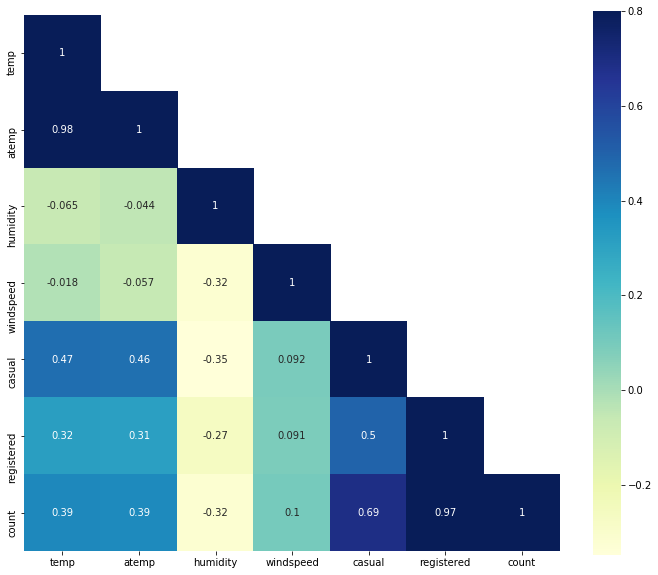

In [18]:
mask = np.array(df_train_corr)
#this will make half of the array as 0
mask[np.tril_indices_from(mask)]=False
fig,ax = plt.subplots()
fig.set_size_inches(12,10)
#cmap colors - Yellow, Green, blue
#mask is an array. where value is missing in mask array, nothing will be drawn.
#square is True. each box is a square
# annot is true. each box has a value.
sns.heatmap(df_train_corr,mask=mask,vmax=0.8, square=True,annot=True, cmap='YlGnBu' ,ax=ax)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


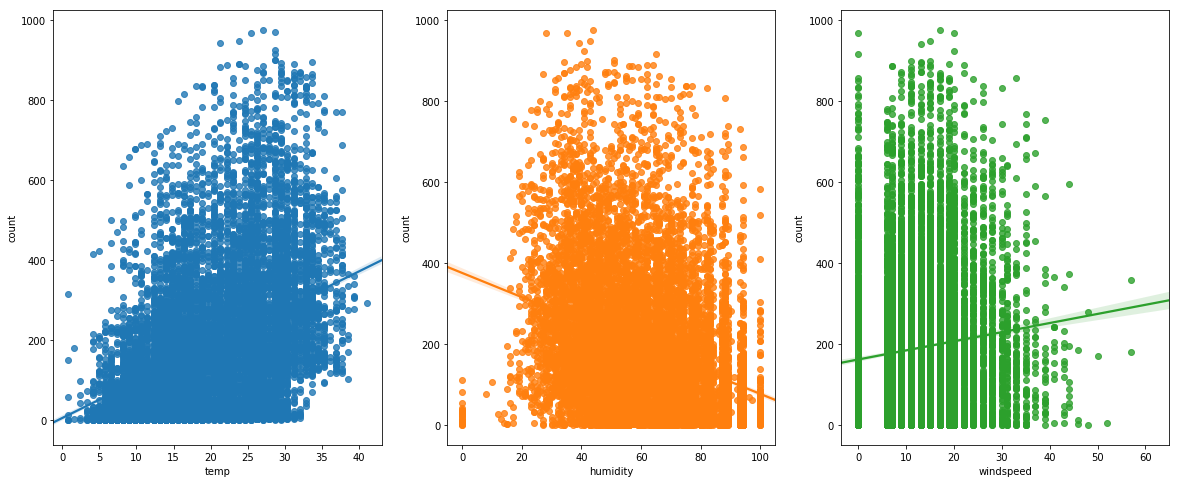

In [19]:
fig,ax = plt.subplots(ncols=3)
fig.set_size_inches(20,8)
sns.regplot(data = df_train,x='temp',y='count',ax=ax[0])
sns.regplot(data = df_train,x='humidity', y='count',ax=ax[1])
sns.regplot(data = df_train,x='windspeed',y='count',ax=ax[2])

In [20]:
from sklearn.ensemble import RandomForestRegressor

In [21]:
df_train.dtypes


season        category
holiday       category
workingday    category
weather       category
temp           float64
atemp          float64
humidity         int64
windspeed      float64
casual           int64
registered       int64
count            int64
date            object
Hour          category
weekday       category
Month         category
dtype: object

In [22]:
columns_for_model = ['season','holiday','workingday','weather','temp','humidity','Hour','weekday','Month']

We have seen correlation between count and temp and humidity.
Let us see the relation between categorical variables against count.
- Season
- Holiday
- Workingday
- weather
- Hour
- Weekday
- Month

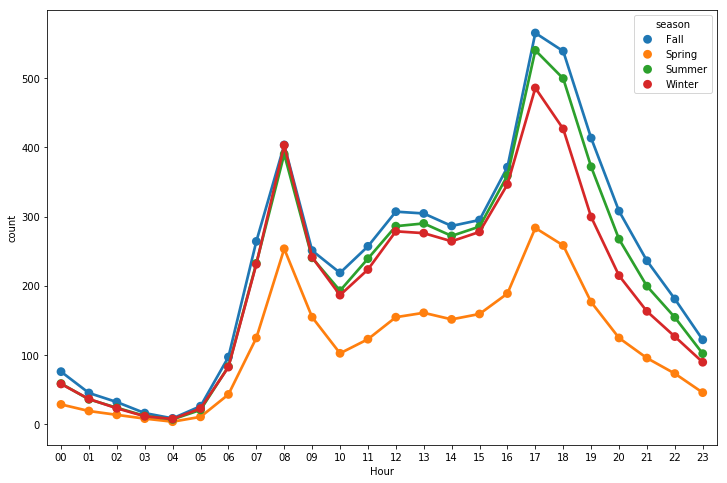

In [23]:
fig,ax = plt.subplots()
fig.set_size_inches(12,8)
df_groupingSeasonHour = pd.DataFrame(df_train.groupby(by=['Hour','season'],sort=True)['count'].mean()).reset_index()
sns.pointplot(data=df_groupingSeasonHour,x=df_groupingSeasonHour['Hour'],y=df_groupingSeasonHour['count'], 
              hue=df_groupingSeasonHour['season'],join=True,ax=ax)


The above graph depicts that during Fall, Summer and Winter, demand for bike is almost same until evening. Overall demand for bike is highest during Fall season and lowest during spring season.

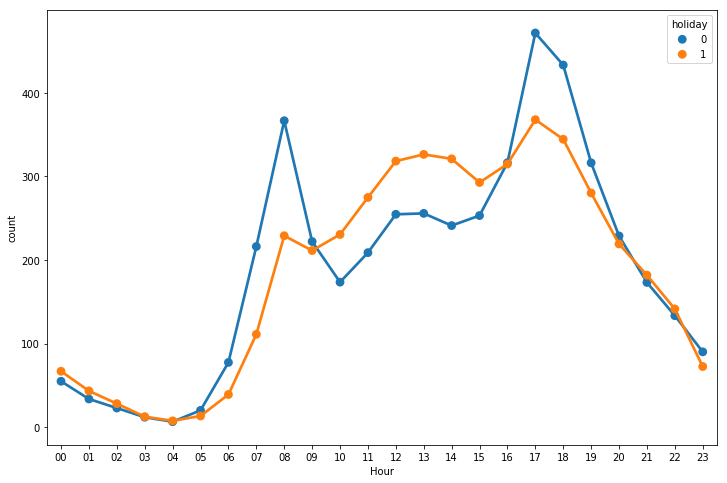

In [24]:
fig,ax = plt.subplots()
fig.set_size_inches(12,8)
df_groupingSeasonHour = pd.DataFrame(df_train.groupby(by=['Hour','holiday'],sort=True)['count'].mean()).reset_index()
sns.pointplot(data=df_groupingSeasonHour,x=df_groupingSeasonHour['Hour'],y=df_groupingSeasonHour['count'], 
              hue=df_groupingSeasonHour['holiday'],join=True,ax=ax)


During holiday, demand is higher that normal seasons, but in non-holiday time, there is a peak in the demand as compared to holiday season at around 0800 hours. but after that demand goes down as compared to holidays. Later in the day at around 1700 hours and 1800 hours again the demand for bike is at highest peak in a non-holiday. Maximum average demand during a holiday goes to around 380 and during non-holidays it goes to around 480 at same time (1700 hours).

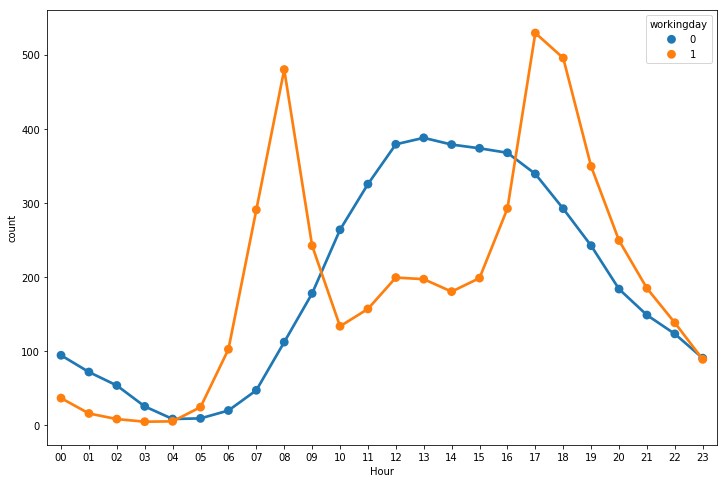

In [25]:
fig,ax = plt.subplots()
fig.set_size_inches(12,8)
df_groupingSeasonHour = pd.DataFrame(df_train.groupby(by=['Hour','workingday'],sort=True)['count'].mean()).reset_index()
sns.pointplot(data=df_groupingSeasonHour,x=df_groupingSeasonHour['Hour'],y=df_groupingSeasonHour['count'], 
              hue=df_groupingSeasonHour['workingday'] ,join=True,ax=ax)


Demand during working day is low in early hours, but increases with time until 800 hours. again it slips down during the day. during evening it attains its peak at around 1700 hours (570 average total demand) and 1800 hours(500 average total demand). during non-working days, the demand descreases in morning till 0500 hours and then it takes a bell curve during the day time with its peak from 1200 to 1600 hours (max avg. 400).

In [26]:
df_train.iloc[np.where(df_train['weekday']=='Monday')]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,Hour,weekday,Month
47,Spring,0,1,Clear + Few clouds + Partly cloudy + Partly cl...,9.02,9.850,44,23.9994,0,5,5,2011-01-03,00,Monday,January
48,Spring,0,1,Clear + Few clouds + Partly cloudy + Partly cl...,8.20,8.335,44,27.9993,0,2,2,2011-01-03,01,Monday,January
49,Spring,0,1,Clear + Few clouds + Partly cloudy + Partly cl...,6.56,6.820,47,26.0027,0,1,1,2011-01-03,04,Monday,January
50,Spring,0,1,Clear + Few clouds + Partly cloudy + Partly cl...,6.56,6.820,47,19.0012,0,3,3,2011-01-03,05,Monday,January
51,Spring,0,1,Clear + Few clouds + Partly cloudy + Partly cl...,5.74,5.305,50,26.0027,0,30,30,2011-01-03,06,Monday,January
52,Spring,0,1,Clear + Few clouds + Partly cloudy + Partly cl...,5.74,6.820,50,12.9980,1,63,64,2011-01-03,07,Monday,January
53,Spring,0,1,Clear + Few clouds + Partly cloudy + Partly cl...,5.74,6.060,50,19.0012,1,153,154,2011-01-03,08,Monday,January
54,Spring,0,1,Clear + Few clouds + Partly cloudy + Partly cl...,6.56,6.820,43,26.0027,7,81,88,2011-01-03,09,Monday,January
55,Spring,0,1,Clear + Few clouds + Partly cloudy + Partly cl...,7.38,8.335,43,16.9979,11,33,44,2011-01-03,10,Monday,January
56,Spring,0,1,Clear + Few clouds + Partly cloudy + Partly cl...,8.20,9.090,40,22.0028,10,41,51,2011-01-03,11,Monday,January


In [27]:
df_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,Hour,weekday,Month
0,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly cl...,9.84,14.395,81,0.0,3,13,16,2011-01-01,00,Saturday,January
1,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly cl...,9.02,13.635,80,0.0,8,32,40,2011-01-01,01,Saturday,January
2,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly cl...,9.02,13.635,80,0.0,5,27,32,2011-01-01,02,Saturday,January
3,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly cl...,9.84,14.395,75,0.0,3,10,13,2011-01-01,03,Saturday,January
4,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly cl...,9.84,14.395,75,0.0,0,1,1,2011-01-01,04,Saturday,January


Based on the results in graph above, it is quite obvious that the count is dependent upon
1. Season
2. holiday
3. working day
4. weather
5. temperature
6. humidity
7. weekday
8. month

So we will read the data again and use the columns mentioned above to create data model also adding the dummies in the process for categorical variables.

In [28]:
#Training set
training_data = pd.read_csv('../input/train.csv')

training_data['date']= training_data['datetime'].apply(lambda x: x.split()[0])
training_data['Hour']=training_data['datetime'].apply(lambda x:x.split()[1].split(':')[0])
training_data['weekday']=training_data['date'].apply(lambda x: calendar.day_name[datetime.strptime(x,'%Y-%m-%d').weekday()])
training_data['Month'] = training_data['date'].apply(lambda x: calendar.month_name[datetime.strptime(x,'%Y-%m-%d').month])

training_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,Hour,weekday,Month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,00,Saturday,January
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,01,Saturday,January
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01,02,Saturday,January
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01,03,Saturday,January
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01,04,Saturday,January


In [29]:
#dropping columns that are not required
training_data.drop(columns=['datetime', 'atemp','windspeed','casual','registered','date'],inplace=True)
training_data.head()

,season,holiday,workingday,weather,temp,humidity,count,Hour,weekday,Month
0,1,0,0,1,9.84,81,16,00,Saturday,January
1,1,0,0,1,9.02,80,40,01,Saturday,January
2,1,0,0,1,9.02,80,32,02,Saturday,January
3,1,0,0,1,9.84,75,13,03,Saturday,January
4,1,0,0,1,9.84,75,1,04,Saturday,January


In [30]:
training_data.dtypes

season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
humidity        int64
count           int64
Hour           object
weekday        object
Month          object
dtype: object

In [31]:
training_data.weekday=training_data.weekday.astype('category')
training_data.Month = training_data.Month.astype('category')
training_data.season = training_data.season.astype('category')
training_data.holiday = training_data.holiday.astype('category')
training_data.workingday = training_data.workingday.astype('category')
training_data.weather = training_data.weather.astype('category')

In [32]:
weekday_dummies = pd.get_dummies(training_data['weekday'])
month_dummies = pd.get_dummies(training_data.Month)
season_dummies = pd.get_dummies(training_data.season)
season_dummies.columns = ['Spring','Summer','Fall','Winter']
weather_dummies = pd.get_dummies(training_data.weather)
weather_dummies.columns = ['Clear','Mist','Snow','Rain']

training_data = pd.concat([training_data,weekday_dummies,month_dummies,season_dummies,weather_dummies],axis=1)

In [33]:
training_data.drop(columns=['season','weather','weekday','Month'],inplace=True)



In [34]:
training_data.columns


Index(['holiday', 'workingday', 'temp', 'humidity', 'count', 'Hour', 'Friday',
       'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'April', 'August', 'December', 'February', 'January', 'July', 'June',
       'March', 'May', 'November', 'October', 'September', 'Spring', 'Summer',
       'Fall', 'Winter', 'Clear', 'Mist', 'Snow', 'Rain'],
      dtype='object')

In [35]:
randomForest = RandomForestRegressor(n_estimators=100)

x_trainingSet = training_data[['holiday', 'workingday', 'temp', 'humidity', 'Hour', 'Friday',
       'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'April', 'August', 'December', 'February', 'January', 'July', 'June',
       'March', 'May', 'November', 'October', 'September', 'Spring', 'Summer',
       'Fall', 'Winter', 'Clear', 'Mist', 'Snow', 'Rain']]
y_trainingSet = training_data['count']

randomForest.fit(x_trainingSet,y_trainingSet)

y_hat_training = randomForest.predict(X=x_trainingSet)

from sklearn.metrics import mean_squared_error
print('Root Mean square error: ',np.sqrt(mean_squared_error(y_trainingSet,y_hat_training)))

Root Mean square error:  24.666566329097066


In [36]:
#Testing set
testing_data = pd.read_csv('../input/test.csv')

testing_data['date']= testing_data['datetime'].apply(lambda x: x.split()[0])
testing_data['Hour']=testing_data['datetime'].apply(lambda x:x.split()[1].split(':')[0])
testing_data['weekday']=testing_data['date'].apply(lambda x: calendar.day_name[datetime.strptime(x,'%Y-%m-%d').weekday()])
testing_data['Month'] = testing_data['date'].apply(lambda x: calendar.month_name[datetime.strptime(x,'%Y-%m-%d').month])

testing_data.drop(columns=['datetime', 'atemp','windspeed','date'],inplace=True)

testing_data.weekday=testing_data.weekday.astype('category')
testing_data.Month = testing_data.Month.astype('category')
testing_data.season = testing_data.season.astype('category')
testing_data.holiday = testing_data.holiday.astype('category')
testing_data.workingday = testing_data.workingday.astype('category')
testing_data.weather = testing_data.weather.astype('category')

weekday_dummies = pd.get_dummies(testing_data['weekday'])
month_dummies = pd.get_dummies(testing_data.Month)
season_dummies = pd.get_dummies(testing_data.season)
season_dummies.columns = ['Spring','Summer','Fall','Winter']
weather_dummies = pd.get_dummies(testing_data.weather)
weather_dummies.columns = ['Clear','Mist','Snow','Rain']

testing_data = pd.concat([testing_data,weekday_dummies,month_dummies,season_dummies,weather_dummies],axis=1)

testing_data.drop(columns=['season','weather','weekday','Month'],inplace=True)

x_testSet = testing_data[['holiday', 'workingday', 'temp', 'humidity', 'Hour', 'Friday',
       'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'April', 'August', 'December', 'February', 'January', 'July', 'June',
       'March', 'May', 'November', 'October', 'September', 'Spring', 'Summer',
       'Fall', 'Winter', 'Clear', 'Mist', 'Snow', 'Rain']]

y_hat_testing = randomForest.predict(X=x_testSet)


In [37]:
y_hat_testing.shape

(6493,)

In [38]:
testing_data.head()

,holiday,workingday,temp,humidity,Hour,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,April,August,December,February,January,July,June,March,May,November,October,September,Spring,Summer,Fall,Winter,Clear,Mist,Snow,Rain
0,0,1,10.66,56,00,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
1,0,1,10.66,56,01,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2,0,1,10.66,56,02,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
3,0,1,10.66,56,03,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
4,0,1,10.66,56,04,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


In [39]:
testing_col = pd.read_csv('../input/test.csv')
testing_col.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [40]:

final_dataframe = pd.DataFrame({"datetime": testing_col.datetime,"count":[int(x) for  x in y_hat_testing]})

In [41]:
final_dataframe.to_csv('bike_prediction.csv',index=False)